<a href="https://colab.research.google.com/github/AneeshYaramati/pothole-detection/blob/main/pothole_detection_new_code4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install MMDetection**

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!nvcc -V
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
!pip install -U torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html
!pip install mmcv-full
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection
%cd mmdetection
!pip install -e .

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.3 MB/s eta 0:04:08tcmalloc: large alloc 1147494400 bytes == 0x557ce6458000 @  0x7fba711ee615 0x557cacf543bc 0x557cad03518a 0x557cacf571cd 0x557cad049b3d 0x557cacfcb458 0x557cacfc602f 0x557cacf58aba 0x557cacfcb2c0 0x557cacfc602f 0x557cacf58aba 0x557cacfc7cd4 0x557cad04a986 0x557cacfc7350 0x557cad04a986 0x557cacfc7350 0x557cad04a986 0x557cacfc7350 0x557cacf58f19 0x557cacf9ca79 0x557cacf57b32 0x557cacfcb1dd 0x557cacfc602f 0x557cacf58aba 0x557cacfc7cd4 0x557cacfc602f 0x557cacf58aba 0x557cacfc6eae 0x557cacf589da 0x557cacfc7108 0x557cacfc602f
     |█████████████████████████████▏  | 1055.7 MB 1.3 MB/s eta 0:01:20tcmalloc: large alloc 1434370048 bytes == 0x557d2aaae000 @  0x7fba711ee615 0x557cacf543bc 0x557cad03518a 0x557cacf571cd 0x557cad049b3d 0x557cacfcb458 0x557cacfc602f 0x557cacf58aba 0x557cacfcb2c0 0x557cacfc602f 0x557cacf58aba 0x557cacfc7cd4 0x557cad04a986 0x557cacfc73

In [4]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

import mmdet
print(mmdet.__version__)

from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())
import os
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
import glob
import cv2
import shutil
import random
import os.path as osp
import json
import mmcv
import random
import re
import xml.etree.ElementTree as ET
from typing import Dict, List
from mmdet.apis import set_random_seed
import pandas as pd
import numpy as np
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

1.7.1+cu110 True
2.21.0
11.1
GCC 7.5


In [ ]:
!unzip '/gdrive/MyDrive/pothole/archive.zip' -d '/gdrive/MyDrive/pothole/'

Archive:  /gdrive/MyDrive/pothole/archive.zip
  inflating: /gdrive/MyDrive/pothole/README.md  
  inflating: /gdrive/MyDrive/pothole/annotated-images/img-1.jpg  
  inflating: /gdrive/MyDrive/pothole/annotated-images/img-1.xml  
  inflating: /gdrive/MyDrive/pothole/annotated-images/img-10.jpg  
  inflating: /gdrive/MyDrive/pothole/annotated-images/img-10.xml  
  inflating: /gdrive/MyDrive/pothole/annotated-images/img-100.jpg  
  inflating: /gdrive/MyDrive/pothole/annotated-images/img-100.xml  
  inflating: /gdrive/MyDrive/pothole/annotated-images/img-101.jpg  
  inflating: /gdrive/MyDrive/pothole/annotated-images/img-101.xml  
  inflating: /gdrive/MyDrive/pothole/annotated-images/img-102.jpg  
  inflating: /gdrive/MyDrive/pothole/annotated-images/img-102.xml  
  inflating: /gdrive/MyDrive/pothole/annotated-images/img-103.jpg  
  inflating: /gdrive/MyDrive/pothole/annotated-images/img-103.xml  
  inflating: /gdrive/MyDrive/pothole/annotated-images/img-104.jpg  
  inflating: /gdrive/MyDriv

In [5]:
global_seed = 0

def set_seed(seed=global_seed):
    """Sets the random seeds."""
    set_random_seed(seed, deterministic=False)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

In [6]:
%cd /gdrive/MyDrive/pothole/annotated-images

/gdrive/MyDrive/pothole/annotated-images


# **Convert PASCAL VOC to COCO**

In [7]:
with open('/gdrive/MyDrive/pothole/splits.json','r') as f:
    data = json.loads(f.read())

In [8]:
%%writefile labels.txt
pothole

Overwriting labels.txt


In [ ]:
with open('train.txt', 'x') as f:
    for train_file in data['train']:
        f.write('/gdrive/MyDrive/pothole/annotated-images/' + train_file)
        f.write('\n')
f.close()

In [ ]:
with open('val.txt', 'x') as f:
    for val_file in data['test']:
        f.write('/gdrive/MyDrive/pothole/annotated-images/' + val_file)
        f.write('\n')
f.close()

In [9]:
#Stolen from https://github.com/yukkyo/voc2coco
def get_label2id(labels_path: str) -> Dict[str, int]:
    with open(labels_path, 'r') as f:
        labels_str = f.read().split()
    labels_ids = list(range(1, len(labels_str)+1))
    return dict(zip(labels_str, labels_ids))


def get_annpaths(ann_dir_path: str = None,
                 ann_ids_path: str = None,
                 ext: str = '',
                 annpaths_list_path: str = None) -> List[str]:
    # If use annotation paths list
    if annpaths_list_path is not None:
        with open(annpaths_list_path, 'r') as f:
            ann_paths = f.read().split()
        return ann_paths

    # If use annotaion ids list
    ext_with_dot = '.' + ext if ext != '' else ''
    with open(ann_ids_path, 'r') as f:
        ann_ids = f.read().split()
    ann_paths = [os.path.join(ann_dir_path, aid+ext_with_dot) for aid in ann_ids]
    return ann_paths


def get_image_info(annotation_root, extract_num_from_imgid=True):
#     path = annotation_root.findtext('path')
#     if path is None:
    filename = annotation_root.findtext('filename')
#     else:
#         filename = os.path.basename(path)
    img_name = os.path.basename(filename)
    img_id = os.path.splitext(img_name)[0]
    if extract_num_from_imgid and isinstance(img_id, str):
        img_id = int(re.findall(r'\d+', img_id)[0])

    size = annotation_root.find('size')
    width = int(size.findtext('width'))
    height = int(size.findtext('height'))

    image_info = {
        'id': img_id,
        'width': width,
        'height': height,
        'file_name': filename,
    }
    return image_info


def get_coco_annotation_from_obj(obj, label2id):
    label = obj.findtext('name')
#     assert label in label2id, f"Error: {label} is not in label2id !"
    category_id = label2id[label]
    bndbox = obj.find('bndbox')
    xmin = int(float(bndbox.findtext('xmin')))
    ymin = int(float(bndbox.findtext('ymin')))
    xmax = int(float(bndbox.findtext('xmax')))
    ymax = int(float(bndbox.findtext('ymax')))
    assert xmax >= xmin and ymax >= ymin, f"Box size error !: (xmin, ymin, xmax, ymax): {xmin, ymin, xmax, ymax}"
    o_width = xmax - xmin
    o_height = ymax - ymin
    ann = {
        'category_id': category_id,
        'segmentation': [],  # This script is not for segmentation
        'area': o_width * o_height,
        'bbox': [xmin, ymin, o_width, o_height],
        'iscrowd': 0,
    }
    return ann


def convert_xmls_to_cocojson(annotation_paths: List[str],\
                             label2id: Dict[str, int],
                             output_jsonpath: str,
                             extract_num_from_imgid: bool = True):
    output_json_dict = {
        "images": [],
        "annotations": [],
        "categories": []
    }
    bnd_id = 1  # START_BOUNDING_BOX_ID, TODO input as args ?
    print('Start converting !')
    for a_path in annotation_paths:
        # Read annotation xml
        ann_tree = ET.parse(a_path)
        ann_root = ann_tree.getroot()

        img_info = get_image_info(annotation_root=ann_root,
                                  extract_num_from_imgid=extract_num_from_imgid)
        img_id = img_info['id']
        output_json_dict['images'].append(img_info)

        for obj in ann_root.findall('object'):
            ann = get_coco_annotation_from_obj(obj=obj, label2id=label2id)
            annot = {'id': bnd_id, 'image_id': img_id,}
            annot.update(ann)
            output_json_dict['annotations'].append(annot)
            bnd_id = bnd_id + 1

    for label, label_id in label2id.items():
        category_info = {'id': label_id, 'name': label, 'supercategory': 'none'}
        output_json_dict['categories'].append(category_info)

    with open(output_jsonpath, 'w') as f:
        output_json = json.dumps(output_json_dict)
        f.write(output_json)

In [ ]:
def convert_to_coco(ann_path_list='/gdrive/MyDrive/pothole/annotated-images/train.txt', labels='/gdrive/MyDrive/pothole/annotated-images/labels.txt', output='/gdrive/MyDrive/pothole/annotated-images/output.json'):
    label2id = get_label2id(labels_path=labels)
    ann_paths = get_annpaths(
        annpaths_list_path=ann_path_list
    )
    convert_xmls_to_cocojson(
        annotation_paths=ann_paths,
        label2id=label2id,
        output_jsonpath=output
    )

In [ ]:
convert_to_coco()

Start converting !


An interesting observation with this dataset is that there are some bboxes with the same xmin and xmax. 

In [ ]:
convert_to_coco(ann_path_list='/gdrive/MyDrive/pothole/annotated-images/val.txt', labels='/gdrive/MyDrive/pothole/annotated-images/labels.txt', output='/gdrive/MyDrive/pothole/annotated-images/val_output.json')

Start converting !


In [28]:
from mmcv import Config
cfg = Config.fromfile('/content/mmdetection/configs/dcn/cascade_rcnn_r101_fpn_dconv_c3-c5_1x_coco.py')

In [29]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'CocoDataset'
cfg.classes = '/gdrive/MyDrive/pothole/annotated-images/labels.txt'
cfg.data_root = '/gdrive/MyDrive/pothole/annotated-images'

for head in cfg.model.roi_head.bbox_head:
    head.num_classes = 1

cfg.data.test.type = 'CocoDataset'
cfg.data.test.classes = 'labels.txt'
cfg.data.test.data_root = '/gdrive/MyDrive/pothole/annotated-images'
cfg.data.test.ann_file = 'val_output.json'
cfg.data.test.img_prefix = '/gdrive/MyDrive/pothole/annotated-images'

cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = '/gdrive/MyDrive/pothole/annotated-images'
cfg.data.train.ann_file = 'output.json'
cfg.data.train.img_prefix = '/gdrive/MyDrive/pothole/annotated-images'
cfg.data.train.classes = 'labels.txt'

cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = '/gdrive/MyDrive/pothole/annotated-images'
cfg.data.val.ann_file = 'val_output.json'
cfg.data.val.img_prefix = '/gdrive/MyDrive/pothole/annotated-images'
cfg.data.val.classes = 'labels.txt'

albu_train_transforms = [
    dict(type='ShiftScaleRotate', shift_limit=0.0625,
         scale_limit=0.15, rotate_limit=15, p=0.4),
    dict(type='RandomBrightnessContrast', brightness_limit=0.2,
         contrast_limit=0.2, p=0.5),
    dict(type='IAAAffine', shear=(-10.0, 10.0), p=0.4),
#     dict(type='MixUp', p=0.2, lambd=0.5),
    dict(type="Blur", p=1.0, blur_limit=7),
    dict(type='CLAHE', p=0.5),
    dict(type='Equalize', mode='cv', p=0.4),
    dict(
        type="OneOf",
        transforms=[
            dict(type="GaussianBlur", p=1.0, blur_limit=7),
            dict(type="MedianBlur", p=1.0, blur_limit=7),
        ],
        p=0.4,
    ),]

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Albu',
        transforms=albu_train_transforms,
        bbox_params=dict(
        type='BboxParams',
        format='coco',
        label_fields=['gt_labels'],
        min_visibility=0.0,
        filter_lost_elements=True),
        keymap=dict(img='image', gt_bboxes='bboxes'),
        update_pad_shape=False,
        skip_img_without_anno=True),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]

cfg.load_from = '/gdrive/MyDrive/pothole/cascade_rcnn_r101_fpn_dconv_c3-c5_1x_coco_20200203-3b2f0594.pth'

cfg.work_dir = '/gdrive/MyDrive/pothole/annotated-images/model_output'

cfg.optimizer.lr = 0.02 / 8
cfg.lr_config = dict(
    policy='CosineAnnealing', 
    by_epoch=False,
    warmup='linear', 
    warmup_iters=500, 
    warmup_ratio=0.001,
    min_lr=1e-07)

cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu = 2

cfg.evaluation.metric = 'bbox'
cfg.evaluation.interval = 4

cfg.checkpoint_config.interval = 12
cfg.runner.max_epochs = 36
cfg.log_config.interval = 50

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = [0]

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='CascadeRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet101'),
        dcn=dict(type='DCN', deform_groups=1, fallback_on_stride=False),
        stage_with_dcn=(False, True, True, True)),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
     

In [27]:
datasets = [build_dataset(cfg.data.train)]
model = build_detector(
 cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

TypeError: ignored

load checkpoint from local path: /gdrive/MyDrive/pothole/annotated-images/model_output/epoch_36.pth


/content/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


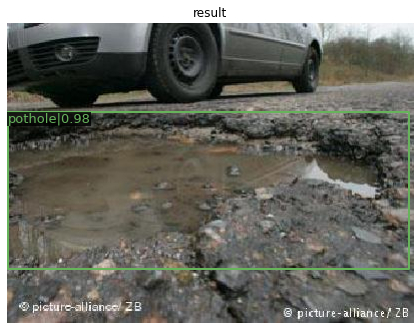

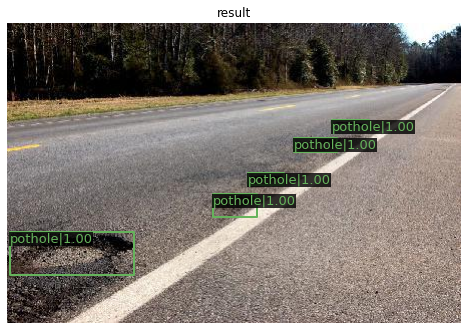

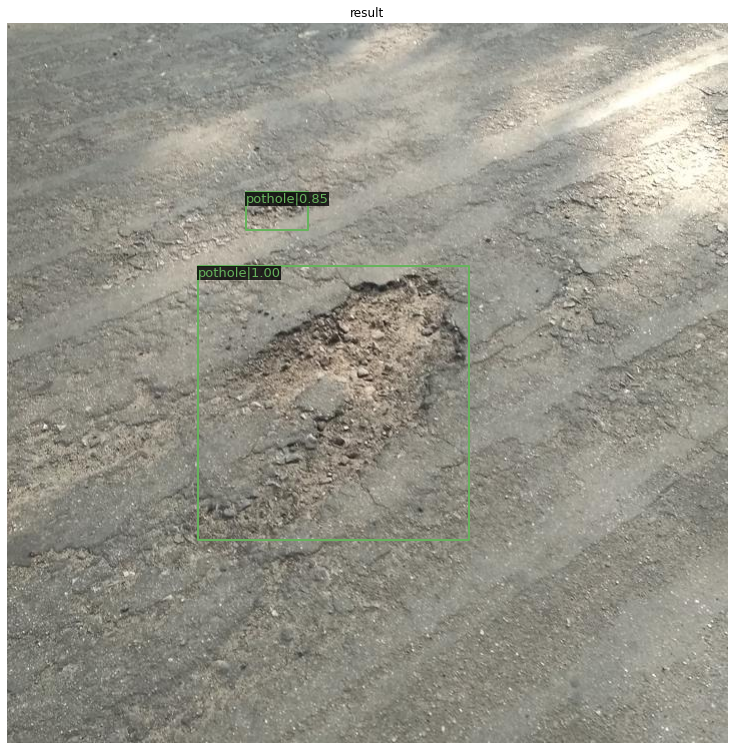

In [30]:
model = init_detector(cfg, '/gdrive/MyDrive/pothole/annotated-images/model_output/epoch_36.pth')
for i in range(3):
    img = data['test'][i][:-3] + 'jpg'
    img = mmcv.imread('/gdrive/MyDrive/pothole/annotated-images/' + img)
    result = inference_detector(model, img)
    show_result_pyplot(model, img, result)

In [43]:

video = mmcv.VideoReader('/gdrive/MyDrive/pothole-video-2.mp4')
for frame in video:
    result = inference_detector(model, frame)
    model.show_result(frame, result, wait_time=1)


KeyboardInterrupt: ignored